In [34]:
# importing the libraries
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [2]:
class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [7]:
data = np.load("/Users/zhangfengzhe/Desktop/UROP/wild_fire_urop_fz920/fire_data/all_304_fire_combine_all_feature_512_wind_precipitation_new.npy")
data.shape

(304, 512, 512, 15)

In [48]:
m, n_H, n_W, n_C = data.shape
train_x = data[:, :, :, 0:14]
train_y = data[:, :, :, 14]
print(train_x.shape)
print(train_y.shape)
len(train_x[1, 1, 1, :])

(304, 512, 512, 14)
(304, 512, 512)


14

In [39]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)

print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(val_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(val_x.shape))
print ("Y_test shape: " + str(val_y.shape))

number of training examples = 273
number of test examples = 31
X_train shape: (273, 512, 512, 13)
Y_train shape: (273, 512, 512)
X_test shape: (31, 512, 512, 13)
Y_test shape: (31, 512, 512)


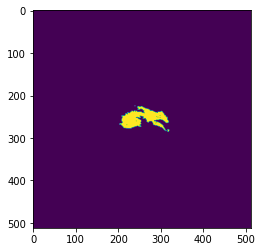

In [49]:
index = 100
plt.imshow(data[index, :, :, 14]) #display sample
plt.show()

In [90]:
model = ConvLSTM(input_dim=[m, 512, 512, 14],
                 hidden_dim=[64, 64, 128],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

TypeError: can only concatenate list (not "int") to list

In [79]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [81]:
train_loader = [train_x, train_y]
test_loader = [val_x, val_y]

In [83]:
for data in test_loader:
    image, label = data[0], data[1]
    print(image.shape)
    print(label.shape)

(512, 512, 13)
(512, 512, 13)
(512, 512)
(512, 512)


In [84]:
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for i in range(m):
            images, labels = val_x[i, :, :, :], val_y[i, :, :]
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return accuracy

In [88]:
from torch.autograd import Variable


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for i in range(m):
            images = torch.tensor(train_x[i, :, :, :])
            labels = torch.tensor(train_y[i, :, :])
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        

In [89]:
train(10)

The model will be running on cpu device


ValueError: not enough values to unpack (expected 5, got 3)